In [1]:
from datamatrix import io
import numpy as np
from matplotlib import pyplot as plt
from datamatrix import operations as ops, DataMatrix, FloatColumn

In [2]:
dm = io.readpickle('outputs/correlation-matrix.pkl')
ldm = io.readtxt('outputs/longish-correlation-matrix.csv')

In [3]:
MAX_ERR = 40


def mask(nft, mask):
    
    nft.get_data()[mask] = np.nan


for row in dm:
    a = row.prf_err.get_data()
    err = np.where(a > MAX_ERR)
    n_poor = len(err[0])
    n_total = np.sum(~np.isnan(a))
    print('poor {} of {}'.format(n_poor, n_total))
    mask(row.prf_x, err)
    mask(row.prf_y, err)
    mask(row.prf_sd, err)
    mask(row.prf_err, err)
    mask(row.r_vc_pupil, err)
    mask(row.r_vc_lc, err)
    

dm.r_pupil = [np.nanmedian(row.r_vc_pupil.get_data()) for row in dm]
dm.r_lc = [np.nanmedian(row.r_vc_lc.get_data()) for row in dm]
print('Before {}'.format(len(ldm)))
ldm = ldm.prf_err <= MAX_ERR
print('After {}'.format(len(ldm)))

/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


poor 132 of 2040
poor 62 of 1056
poor 18 of 296
poor 12 of 256
poor 261 of 2040
poor 106 of 1056
poor 75 of 296
poor 44 of 256
poor 128 of 2040
poor 40 of 1056
poor 11 of 296
poor 7 of 256
poor 230 of 2040
poor 87 of 1056
poor 30 of 296
poor 24 of 256
poor 341 of 2040
poor 135 of 1056
poor 66 of 296
poor 22 of 256
poor 137 of 2040
poor 67 of 1056
poor 13 of 296
poor 8 of 256
poor 131 of 2040
poor 87 of 1056
poor 36 of 296
poor 22 of 256
poor 168 of 2040
poor 86 of 1056
poor 39 of 296
poor 21 of 256
poor 188 of 2040
poor 86 of 1056
poor 33 of 296
poor 22 of 256
poor 313 of 2040
poor 136 of 1056
poor 34 of 296
poor 22 of 256
poor 224 of 2040
poor 110 of 1056
poor 52 of 296
poor 43 of 256
poor 368 of 2040
poor 109 of 1056
poor 38 of 296
poor 24 of 256
poor 218 of 2040
poor 74 of 1056
poor 27 of 296
poor 31 of 256
poor 213 of 2040
poor 114 of 1056
poor 35 of 296
poor 45 of 256
poor 161 of 2040
poor 72 of 1056
poor 29 of 296
poor 13 of 256
Before 26298
After 23982


# Overall correlation per ROI

/home/sebastiaan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


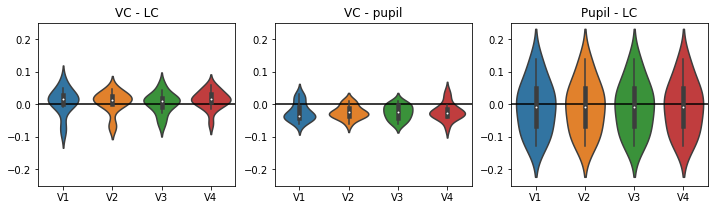

In [4]:
import seaborn as sns

plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.title('VC - LC')
plt.axhline(0, color='black')
plt.ylim(-.25, .25)
sns.violinplot(x='roi', y='r_lc', data=dm)
plt.subplot(1,3,2)
plt.title('VC - pupil')
plt.axhline(0, color='black')
plt.ylim(-.25, .25)
sns.violinplot(x='roi', y='r_pupil', data=dm)
plt.subplot(1,3,3)
plt.title('Pupil - LC')
plt.axhline(0, color='black')
plt.ylim(-.25, .25)
sns.violinplot(x='roi', y='r_lc_pupil', data=dm)

In [5]:
from scipy import stats
from datamatrix import operations as ops
for roi, rdm in ops.split(dm.roi):
    t, p = stats.ttest_1samp(rdm.r_lc, 0)
    print('{}: t({}) = {:.2f}, p = {:4f}'.format(roi, len(rdm) - 1, t, p))

V1: t(14) = 0.82, p = 0.424123
V2: t(14) = 0.81, p = 0.428870
V3: t(14) = 0.59, p = 0.562441
V4: t(14) = 1.94, p = 0.073330


In [6]:
from datamatrix import convert as cnv
from pandas import pivot_table
pivot_table = cnv.wrap_pandas(pivot_table)

pm = pivot_table(dm, values='r_pupil', index='sub', columns='roi')
io.writetxt(pm, 'outputs/pivot-r-vc-pupil.csv')
pm = pivot_table(dm, values='r_lc', index='sub', columns='roi')
io.writetxt(pm, 'outputs/pivot-r-vc-lc.csv')

# Correlations with RF properties

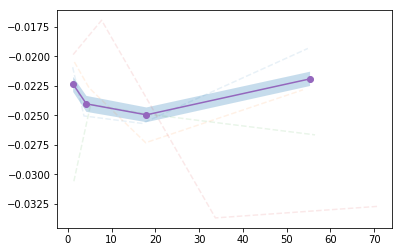

In [7]:
def bin_plot(dm, x, y, label=None, bins=4):

#     if roi not in ['V1', 'V2']:
#         return
    lx = []
    ly = []
    lmin = []
    lmax = []
    for bdm in ops.bin_split(dm[x], bins=bins):
        lx.append(bdm[x].mean)
        ly.append(bdm[y].mean)
        lmin.append(bdm[y].mean - bdm[y].std / len(bdm[y]) ** .5)
        lmax.append(bdm[y].mean + bdm[y].std / len(bdm[y]) ** .5)
    if label:
        alpha = .1
        fmt = '--'
    else:
        alpha = 1
        label = 'Overall'
        fmt = 'o-'
        plt.fill_between(lx, lmin, lmax, alpha=.25)
    plt.plot(lx, ly, fmt, label=label, alpha=alpha)
    

for i, (roi, rdm) in enumerate(ops.split(ldm.roi)):
    bin_plot(rdm, 'ecc', 'r_vc_pupil', roi)
bin_plot(ldm, 'ecc', 'r_vc_pupil')


In [8]:
from datamatrix.rbridge import lme4

lm = lme4.lmer(ldm, 'r_vc_pupil ~ prf_sd + (1+prf_sd|sub)')
lm

Initializing cache ...
@cached: calling <function lmer at 0x7ffa7b6a1510>


/home/sebastiaan/python-libs/datamatrix/io/_text.py:52: DeprecationWarning: 'U' mode is deprecated
  with safe_open(path, u'Ur') as csvfile:


df,effect,est,p,se,t
13.9935855416585,(Intercept),-0.0220172022404649,0.00890247655400479,0.00725274238061196,-3.03570719667657
14.0882640458144,prf_sd,-5.50101060847148e-05,0.601344379993896,0.000102923024618427,-0.534478133426968


## Receptive field properties

/home/sebastiaan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


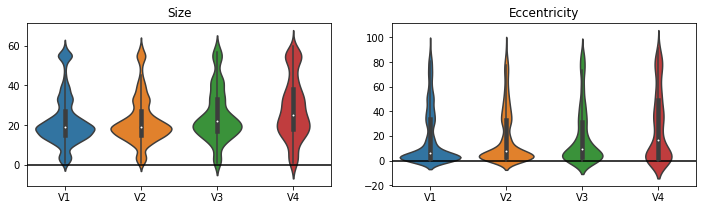

In [9]:
import seaborn as sns

plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.title('Size')
plt.axhline(0, color='black')
sns.violinplot(x='roi', y='prf_sd', data=ldm)
plt.subplot(1,2,2)
plt.title('Eccentricity')
plt.axhline(0, color='black')
sns.violinplot(x='roi', y='ecc', data=ldm)